In [1]:
import numpy as np 
import pandas as pd 
import os

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

In [4]:

def load_images_for_cnn(training_directory, batch_size=32, target_size=(224, 224), keyword="Grape"):
    data_generator = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
    )

    train_generator = data_generator.flow_from_directory(
        training_directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        classes=[dir for dir in os.listdir(training_directory) if keyword in dir]
    )

    validation_generator = data_generator.flow_from_directory(
        training_directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        classes=[dir for dir in os.listdir(training_directory) if keyword in dir]
    )

    return train_generator, validation_generator


In [5]:

train_generator, validation_generator = load_images_for_cnn('/kaggle/input/plantvillage-dataset/color', batch_size=32, target_size=(224, 224), keyword="Grape")


Found 3251 images belonging to 4 classes.
Found 811 images belonging to 4 classes.


# Residual Ve SE Bloklu Kod

In [15]:
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Reshape, Dense, Multiply, Input, Add
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

In [16]:
def custom_residual_block(input_tensor, ratio=16):
    x = Conv2D(512, (1, 1), strides=(1, 1), use_bias=False)(input_tensor)
    x = se_block(x, ratio)  
    x = Conv2D(512, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = se_block(x, ratio)  
    x = Conv2D(2048, (1, 1), strides=(1, 1), use_bias=False)(x)
    shortcut = Conv2D(2048, (1, 1), strides=(1, 1), use_bias=False)(input_tensor)
    x = Add()([x, shortcut])
    return x

In [17]:
# Squeeze-and-Excitation bloğu
def se_block(input_tensor, ratio=16):
    channel = input_tensor.shape[-1]
    x = GlobalAveragePooling2D()(input_tensor)
    x = Dense(channel // ratio, activation='relu')(x)
    x = Dense(channel, activation='sigmoid')(x)
    x = Reshape((1, 1, channel))(x)
    return Multiply()([input_tensor, x])

In [18]:
input_tensor = Input(shape=(224, 224, 3))
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

In [19]:
# residual blok
x = custom_residual_block(base_model.output)


x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=predictions)

In [20]:

#residual blokları eğitilmesi
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
history = model.fit(
    train_generator,
    
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=60,
)


Epoch 1/60
101/101 [==============================] - 64s 577ms/step - loss: 1.4426 - accuracy: 0.3858 - val_loss: 1.0670 - val_accuracy: 0.4837
Epoch 2/60
101/101 [==============================] - 55s 547ms/step - loss: 1.2011 - accuracy: 0.4641 - val_loss: 1.0548 - val_accuracy: 0.4837
Epoch 3/60
101/101 [==============================] - 55s 540ms/step - loss: 1.0482 - accuracy: 0.5440 - val_loss: 1.0322 - val_accuracy: 0.5075
Epoch 4/60
101/101 [==============================] - 54s 538ms/step - loss: 1.0753 - accuracy: 0.5120 - val_loss: 1.2268 - val_accuracy: 0.5225
Epoch 5/60
101/101 [==============================] - 54s 534ms/step - loss: 1.0781 - accuracy: 0.5231 - val_loss: 1.0193 - val_accuracy: 0.5113
Epoch 6/60
101/101 [==============================] - 55s 543ms/step - loss: 0.9882 - accuracy: 0.5604 - val_loss: 0.9105 - val_accuracy: 0.6025
Epoch 7/60
101/101 [==============================] - 55s 544ms/step - loss: 0.9718 - accuracy: 0.5716 - val_loss: 0.8915 - val_ac

# Epoch sayısı artarsa acc artıp loss düşüyor(Çok uzun sürdüğünden rapora yakın eğitirim)

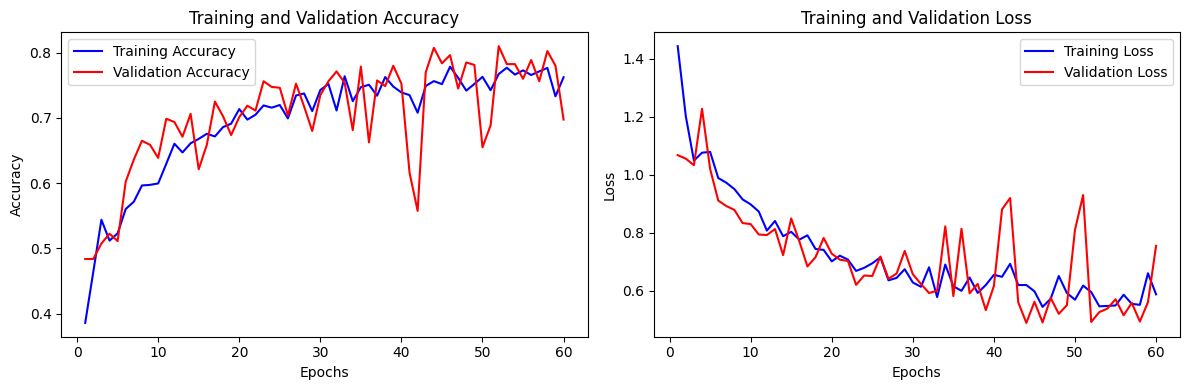

In [22]:

#Görselleşitrme
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')

plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Residual Ve SE Bloklar 

**** Residual Bloklar : Ağın daha derin olmasını sağlar girdi değeri ile çıktı değerini belli bir işlem aşamasından sonra toplar  ****
 
> Girdi=x

> ilk katman (relu)=f(x)

> ikinci katman (relu) =g(f(x))

> residual =x-g(f(x))

> sonuç :x + residual(x-g(f(x)))

* Buradaki temel amaç girdi bloğu orjinal bilgileri içerirken ,residual blok ise daha fazla bilgi ekleyerek ağın daha derin olmasını sağlar.aynı
* zamanda ağın overfitting olmasınıda engeller 


**** Squeeze And Excitation Blok (SE) ****

1.  Girdi çekirdeğinden önemli özellikleri çıkarmak için kullanılır 

> Girdi :x (Konvolüsyon katmanından gelen çıktı)

> Squeeze : Global avarege pooling ile önemli özellikler çıkarılır

> Excitation : Sıkıştılmış bilgileri kullanarak iki tam bağlantılı katman kullanarak hangi özelliklerin öne çıkacağı belirtilir

* Sonuç :SE blokları girdinin önemli özelliklerini daha iyi vurgulamak ve ağı daha etkili hale getirmek için kullanılır 

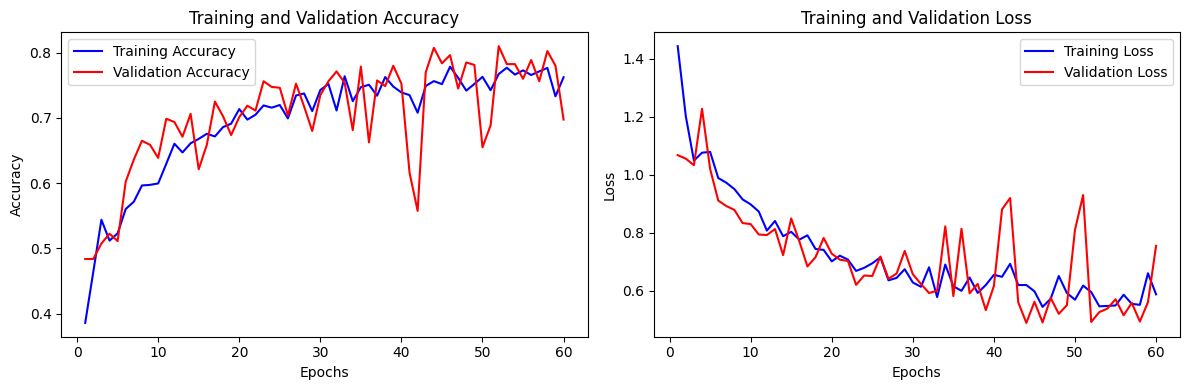

In [23]:
# Eğitim ve doğrulama kayıp ve başarı grafiği
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 36ms/step


ValueError: num must be an integer with 1 <= num <= 20, not 21

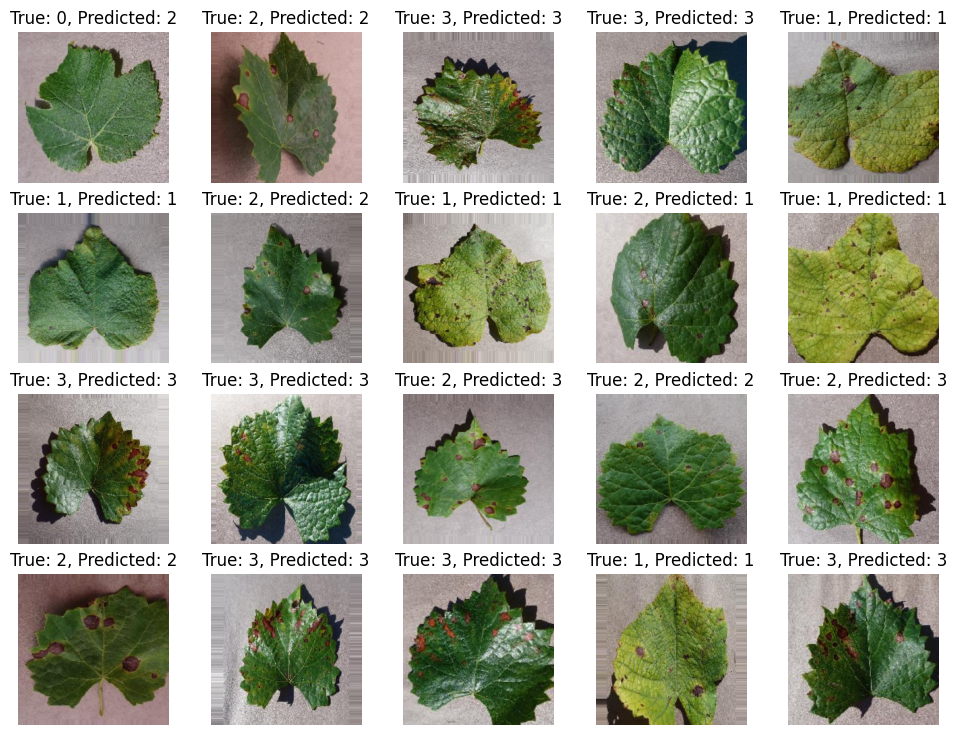

In [26]:
# Tahmin edilen bazı örnekler
sample_images, sample_labels = next(validation_generator) 
sample_predictions = model.predict(sample_images)

num_samples = len(sample_images)
num_rows = 4
num_cols = 5

plt.figure(figsize=(12, 9))
for i in range(num_samples):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(sample_images[i])
    true_label = np.argmax(sample_labels[i])
    predicted_label = np.argmax(sample_predictions[i])
    plt.title(f'True: {true_label}, Predicted: {predicted_label}')
    plt.axis('off')

plt.show()


1/1 [==============================] - 1s 967ms/step


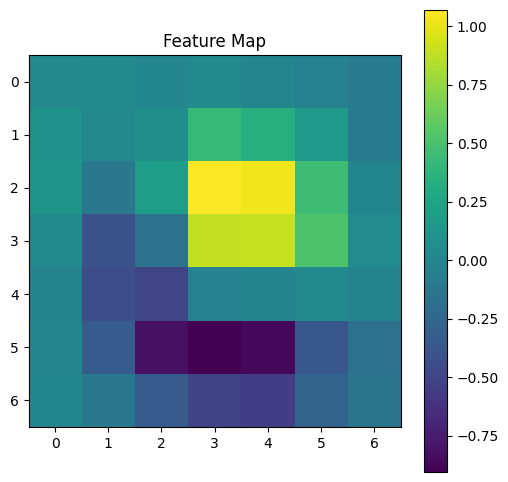

In [29]:

# Feature Map

feature_map_model = Model(inputs=model.input, outputs=model.layers[-6].output)  


sample_image = sample_images[0]


feature_map = feature_map_model.predict(sample_image.reshape(1, 224, 224, 3))


plt.figure(figsize=(6, 6))
plt.imshow(feature_map[0, :, :, 0], cmap='viridis')
plt.title('Feature Map')
plt.colorbar()
plt.show()



Found 3251 images belonging to 4 classes.
Found 811 images belonging to 4 classes.
26/26 [==============================] - 13s 448ms/step


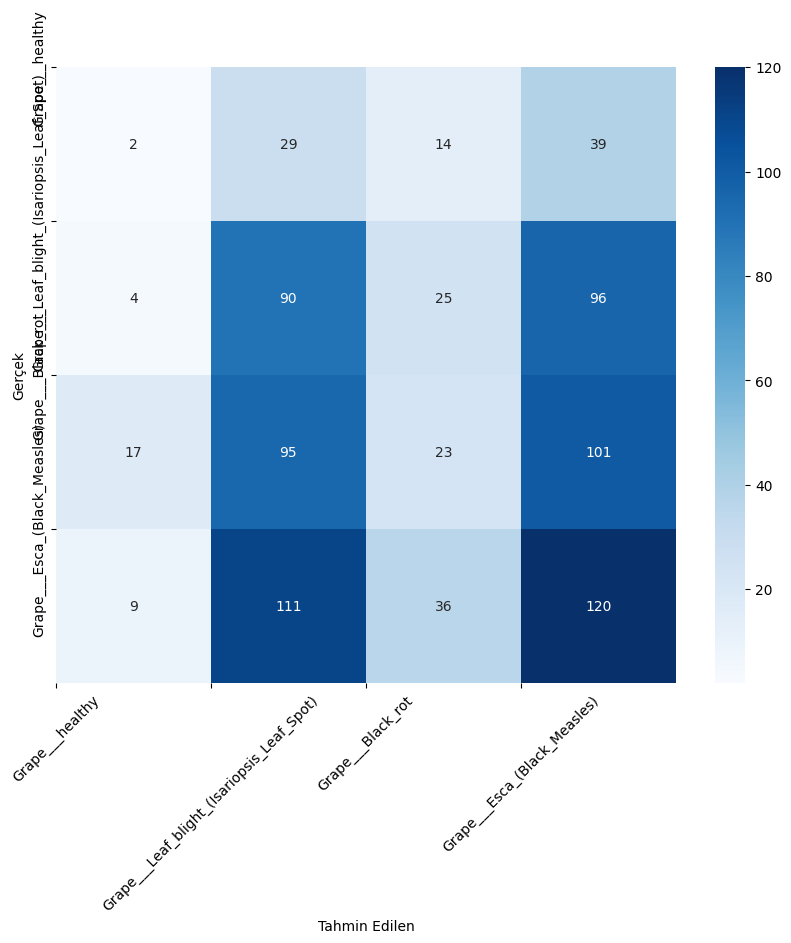

In [33]:
import os
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


training_directory = "/kaggle/input/plantvillage-dataset/color"  
batch_size = 32
target_size = (224, 224)
keyword = "Grape"

train_generator, validation_generator = load_images_for_cnn(training_directory, batch_size, target_size, keyword)


y_pred = model.predict(validation_generator)  


y_true = validation_generator.classes


confusion_mtx = confusion_matrix(y_true, np.argmax(y_pred, axis=1))


plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')


class_names = list(validation_generator.class_indices.keys()) 
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)


plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')

plt.show()
